8/8 [==============================] - 0s 3ms/step
Epoch 1/100
8/8 [==============================] - 1s 6ms/step - loss: 3751.7791
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 1194.0677
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 910.7283
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 779.1398
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 694.9953
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 630.7513
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 575.8708
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 526.7983
Epoch 9/100
8/8 [==============================] - 0s 5ms/step - loss: 481.4295
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 439.2804
Epoch 11/100
8/8 [==============================] - 0s 10ms/step - loss: 400.0462
Epoch 12/100
8/8 [==============================] - 0s 5ms/step 

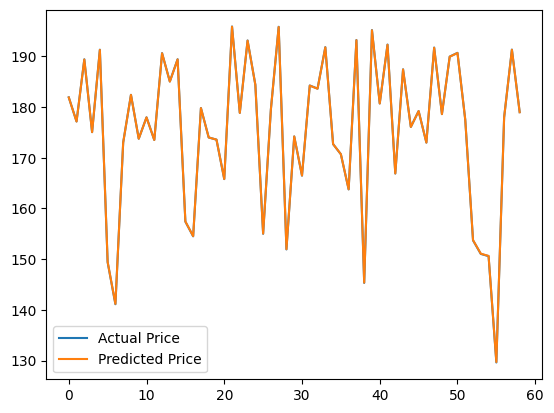

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score


data = pd.read_csv('/content/Apple_stock_yahoo_closehigh.csv', thousands=',')
data = data[['Date', 'Close']]
data['Close'] = data['Close'].apply(lambda x: float(x))


close_fft = np.fft.fft(np.asarray(data['Close'].tolist()))
fft_df = pd.DataFrame({'fft': close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

fft_list = np.asarray(fft_df['fft'].tolist())
fft_list[500:-500] = 0


filtered_close = np.fft.ifft(fft_list)


data['Filtered_Close'] = filtered_close.real


X = data[['Filtered_Close']]
y = data['Close']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


def weighted_mse(y_true, y_pred):

  predicted_sigma = y_pred[:, 1]

  weights = 1 / (predicted_sigma + 1e-8)


  squared_error = keras.backend.square(y_true[:, 0] - y_pred[:, 0])


  weighted_squared_error = squared_error * weights


  return keras.backend.mean(weighted_squared_error)



model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(1,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='linear'))
model.compile(optimizer='adam', loss=weighted_mse)
model.fit(X_train, np.concatenate((y_train.values.reshape(-1, 1), np.full_like(y_train.values, np.std(y_train.values - model.predict(X_train)[:, 0])).reshape(-1, 1)), axis=1), epochs=100, batch_size=32)


y_predicted = model.predict(X_test)


predicted_price = y_predicted[:, 0]
predicted_sigma = y_predicted[:, 1]

residuals = y_test.values - predicted_price


simulated_prices = predicted_price + np.random.normal(scale=predicted_sigma, size=len(y_test))


confidence_interval = 2 * predicted_sigma


plt.plot(y_test.values, label='Actual Price')
plt.plot(predicted_price, label='Predicted Price')

plt.legend()
plt.show()

#brownian motion

In [ ]:
r2_test = r2_score(y_test, predicted_price)


mse_test = mean_squared_error(y_test, predicted_price)

print(f'Test R-squared (R2): {r2_test}')
print(f'Test Mean Squared Error (MSE): {mse_test}')

Test R-squared (R2): 0.9999959389474945
Test Mean Squared Error (MSE): 0.0009394163834087522


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score


data = pd.read_csv('/content/Apple_stock_yahoo_closehigh.csv', thousands=',')
data = data[['Date', 'Close']]
data['Close'] = data['Close'].apply(lambda x: float(x))


close_fft = np.fft.fft(np.asarray(data['Close'].tolist()))
fft_df = pd.DataFrame({'fft': close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))


fft_list = np.asarray(fft_df['fft'].tolist())
fft_list[500:-500] = 0


filtered_close = np.fft.ifft(fft_list)


data['Filtered_Close'] = filtered_close.real

data.head()



,Date,Close,Filtered_Close
0,2023-01-03,125.070000,125.070000
1,2023-01-04,126.360001,126.360001
2,2023-01-05,125.019997,125.019997
3,2023-01-06,129.619995,129.619995
4,2023-01-09,130.149994,130.149994


In [ ]:
sent = pd.read_csv('/content/Apple_close_high_sent.csv')
merged_data = pd.merge(data, sent, on='Date', how='left')
merged_data.head()

,Date,Close,Filtered_Close,Unnamed: 0,Sent
0,2023-01-03,125.070000,125.070000,0.0,Negative
1,2023-01-04,126.360001,126.360001,1.0,Neutral
2,2023-01-05,125.019997,125.019997,2.0,Neutral
3,2023-01-06,129.619995,129.619995,3.0,Positive
4,2023-01-09,130.149994,130.149994,4.0,Neutral


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
sentiment_mapping = {'Neutral': 0, 'Positive': 1, 'Negative': 2}
merged_data['Sent'] = merged_data['Sent'].map(sentiment_mapping)

Epoch 1/100
7/7 [==============================] - 5s 31ms/step - loss: 0.1781
Epoch 2/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0377
Epoch 3/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0222
Epoch 4/100
7/7 [==============================] - 0s 30ms/step - loss: 0.0090
Epoch 5/100
7/7 [==============================] - 0s 34ms/step - loss: 0.0099
Epoch 6/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0057
Epoch 7/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0060
Epoch 8/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0055
Epoch 9/100
7/7 [==============================] - 0s 30ms/step - loss: 0.0054
Epoch 10/100
7/7 [==============================] - 0s 36ms/step - loss: 0.0051
Epoch 11/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0049
Epoch 12/100
7/7 [==============================] - 0s 30ms/step - loss: 0.0048
Epoch 13/100
7/7 [==============================]

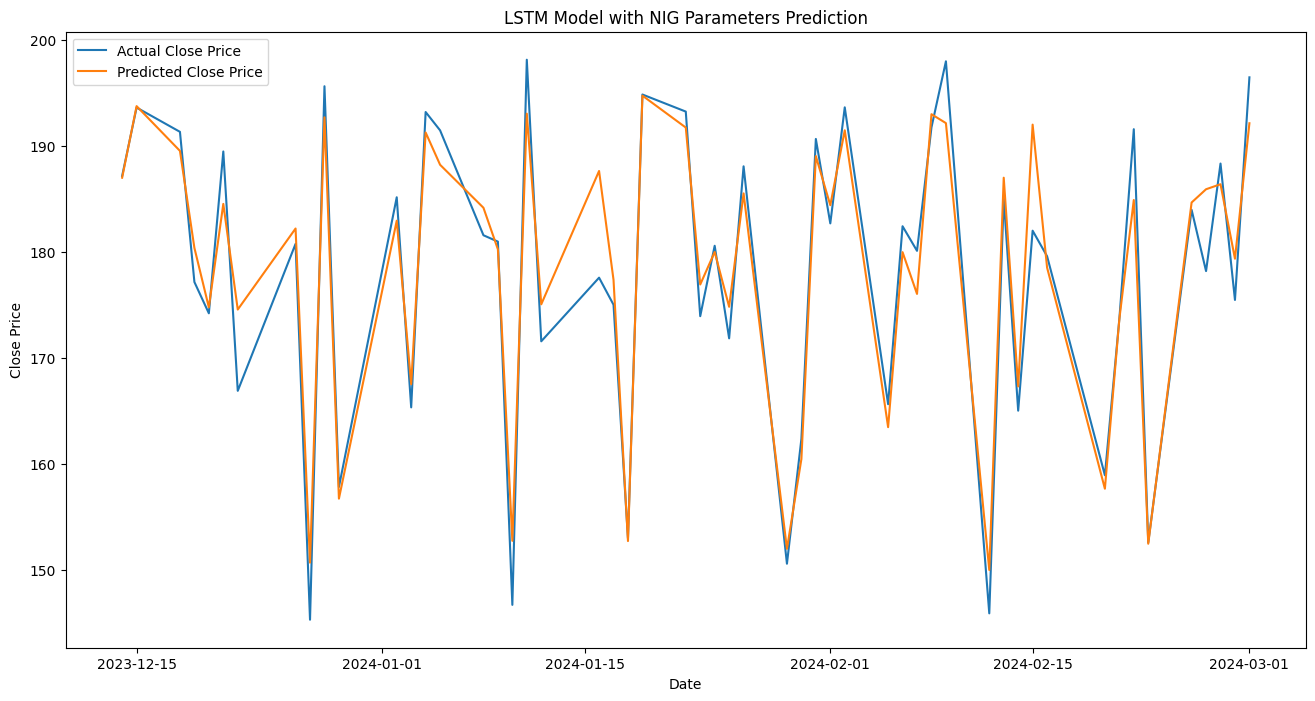

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from scipy import integrate


data_path = '/content/Apple_stock_yahoo_closehigh.csv'
df = pd.read_csv(data_path)


df['Date'] = pd.to_datetime(df['Date'])


data = df[['Close']].values


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


window_size = 30


X, y = [], []
for i in range(window_size, len(data)):
    X.append(scaled_data[i-window_size:i, :])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def estimate_nig_parameters(data):
    # Estimate NIG parameters theta, sigma, and kappa
    log_returns = np.log(data[1:] / data[:-1])
    theta = np.mean(log_returns)
    sigma = np.std(log_returns)
    kappa = 1 / (len(data) - 1) * np.sum((log_returns - theta) ** 2)
    return theta, sigma, kappa

def nig_option_pricing(S0, K, r, T, theta, sigma, kappa):
    # Implement NIG option pricing logic using the Merton model
    # S0: Current stock price
    # K: Option strike price
    # r: Risk-free interest rate
    # T: Time to maturity
    # theta, sigma, kappa: NIG parameters

    # Define parameters for the Merton model
    lambda_ = -theta / kappa
    delta = np.sqrt(theta ** 2 + sigma ** 2 / kappa)
    mu = r - lambda_ * delta - 0.5 * sigma ** 2

    # Calculate the characteristic function of log(S_T)
    def char_func(u):
        return np.exp(T * (1j * u * mu - 0.5 * sigma ** 2 * u ** 2 + kappa * (np.exp(1j * u * np.log(S0)) - 1)))

    # Define the integrand for the option price calculation
    def integrand(u):
        return (np.exp(-1j * u * np.log(K)) * char_func(u) / (1j * u)).real

    # Calculate the option price using numerical integration
    integral_value = integrate.quad(integrand, 0, np.inf)[0]
    option_price = S0 * np.exp(-lambda_ * T) * integral_value / np.pi

    return option_price


theta, sigma, kappa = estimate_nig_parameters(data[:, 0])  # Using Close price for parameter estimation

# Use the estimated parameters as additional features for LSTM
X_train_nig = np.zeros((X_train.shape[0], X_train.shape[1], 5))
X_test_nig = np.zeros((X_test.shape[0], X_test.shape[1], 5))
for i in range(X_train.shape[0]):
    X_train_nig[i, :, 0:2] = X_train[i, :, :]
    X_train_nig[i, :, 2:5] = np.array([theta, sigma, kappa])
for i in range(X_test.shape[0]):
    X_test_nig[i, :, 0:2] = X_test[i, :, :]
    X_test_nig[i, :, 2:5] = np.array([theta, sigma, kappa])


model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 5)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_nig, y_train, epochs=100, batch_size=32)


y_pred = model.predict(X_test_nig)


y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), 1)), y_pred), axis=1))[:, 1]
y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), 1)), y_test.reshape(-1, 1)), axis=1))[:, 1]


r2 = r2_score(y_test_inv, y_pred_inv)
print("R-squared (R2) Value:", r2)


mse = mean_squared_error(y_test_inv, y_pred_inv)
print("Mean Squared Error (MSE):", mse)


plt.figure(figsize=(16, 8))
plt.plot(df['Date'].iloc[-len(y_test):], y_test_inv, label='Actual Close Price')
plt.plot(df['Date'].iloc[-len(y_test):], y_pred_inv, label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('LSTM Model with NIG Parameters Prediction')
plt.legend()
plt.show()

#NIG with only Close

Epoch 1/100
7/7 [==============================] - 4s 30ms/step - loss: 0.1738
Epoch 2/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0326
Epoch 3/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0200
Epoch 4/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0065
Epoch 5/100
7/7 [==============================] - 0s 30ms/step - loss: 0.0081
Epoch 6/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0056
Epoch 7/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0051
Epoch 8/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0048
Epoch 9/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0045
Epoch 10/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0046
Epoch 11/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0043
Epoch 12/100
7/7 [==============================] - 0s 28ms/step - loss: 0.0043
Epoch 13/100
7/7 [==============================]

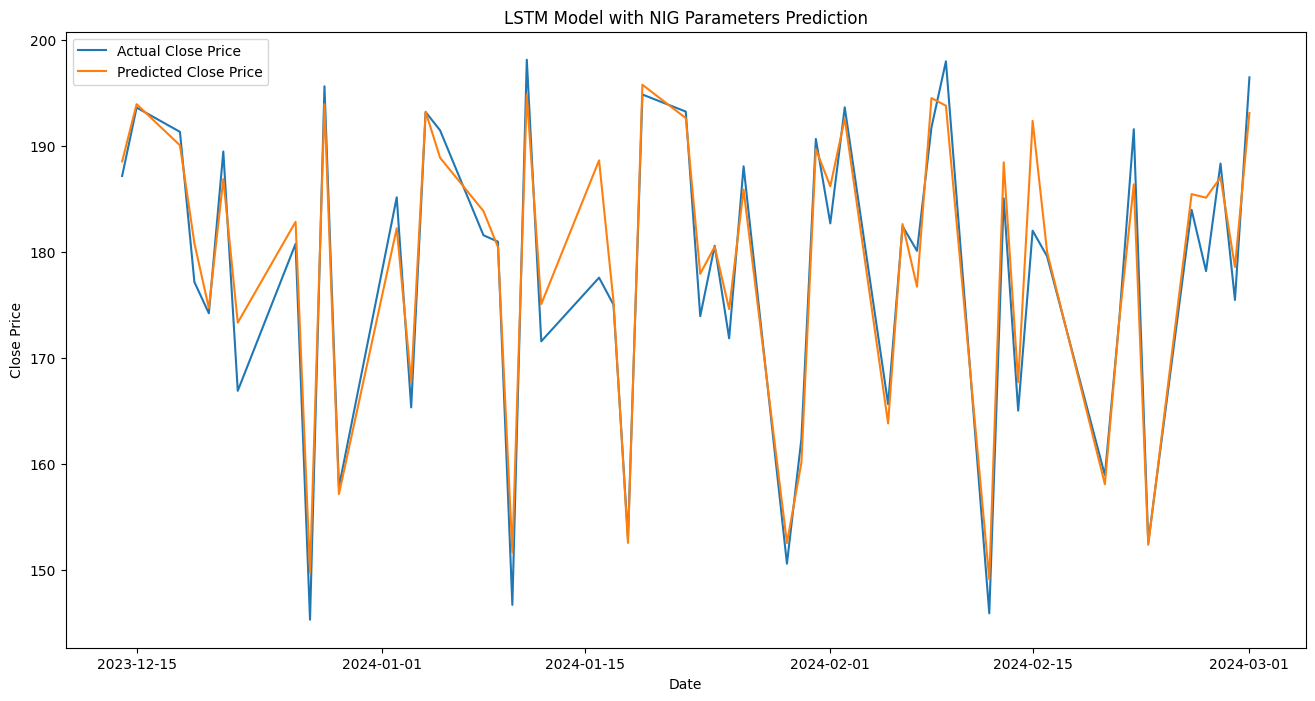

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from scipy import integrate


data_path = '/content/Apple_stock_yahoo_closehigh.csv'
df = pd.read_csv(data_path)


df['Date'] = pd.to_datetime(df['Date'])


data = merged_data[['Filtered_Close']].values


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


window_size = 30


X, y = [], []
for i in range(window_size, len(data)):
    X.append(scaled_data[i-window_size:i, :])
    y.append(scaled_data[i, 0])  # Using Close price as the target variable

X, y = np.array(X), np.array(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def estimate_nig_parameters(data):

    log_returns = np.log(data[1:] / data[:-1])
    theta = np.mean(log_returns)
    sigma = np.std(log_returns)
    kappa = 1 / (len(data) - 1) * np.sum((log_returns - theta) ** 2)
    return theta, sigma, kappa

def nig_option_pricing(S0, K, r, T, theta, sigma, kappa):
    # Implement NIG option pricing logic using the Merton model
    # S0: Current stock price
    # K: Option strike price
    # r: Risk-free interest rate
    # T: Time to maturity
    # theta, sigma, kappa: NIG parameters

    # Define parameters for the Merton model
    lambda_ = -theta / kappa
    delta = np.sqrt(theta ** 2 + sigma ** 2 / kappa)
    mu = r - lambda_ * delta - 0.5 * sigma ** 2

    # Calculate the characteristic function of log(S_T)
    def char_func(u):
        return np.exp(T * (1j * u * mu - 0.5 * sigma ** 2 * u ** 2 + kappa * (np.exp(1j * u * np.log(S0)) - 1)))

    # Define the integrand for the option price calculation
    def integrand(u):
        return (np.exp(-1j * u * np.log(K)) * char_func(u) / (1j * u)).real

    # Calculate the option price using numerical integration
    integral_value = integrate.quad(integrand, 0, np.inf)[0]
    option_price = S0 * np.exp(-lambda_ * T) * integral_value / np.pi

    return option_price

theta, sigma, kappa = estimate_nig_parameters(data[:, 0])


X_train_nig = np.zeros((X_train.shape[0], X_train.shape[1], 5))
X_test_nig = np.zeros((X_test.shape[0], X_test.shape[1], 5))
for i in range(X_train.shape[0]):
    X_train_nig[i, :, 0:2] = X_train[i, :, :]
    X_train_nig[i, :, 2:5] = np.array([theta, sigma, kappa])
for i in range(X_test.shape[0]):
    X_test_nig[i, :, 0:2] = X_test[i, :, :]
    X_test_nig[i, :, 2:5] = np.array([theta, sigma, kappa])


model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 5)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_nig, y_train, epochs=100, batch_size=32)


y_pred = model.predict(X_test_nig)


y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), 1)), y_pred), axis=1))[:, 1]
y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), 1)), y_test.reshape(-1, 1)), axis=1))[:, 1]


r2 = r2_score(y_test_inv, y_pred_inv)
print("R-squared (R2) Value:", r2)


mse = mean_squared_error(y_test_inv, y_pred_inv)
print("Mean Squared Error (MSE):", mse)

plt.figure(figsize=(16, 8))
plt.plot(df['Date'].iloc[-len(y_test):], y_test_inv, label='Actual Close Price')
plt.plot(df['Date'].iloc[-len(y_test):], y_pred_inv, label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('LSTM Model with NIG Parameters Prediction')
plt.legend()
plt.show()

#NIG with filtered close

Epoch 1/100
7/7 [==============================] - 6s 49ms/step - loss: 0.1940
Epoch 2/100
7/7 [==============================] - 0s 47ms/step - loss: 0.0412
Epoch 3/100
7/7 [==============================] - 0s 30ms/step - loss: 0.0181
Epoch 4/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0092
Epoch 5/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0086
Epoch 6/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0050
Epoch 7/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0056
Epoch 8/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0050
Epoch 9/100
7/7 [==============================] - 0s 30ms/step - loss: 0.0045
Epoch 10/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0046
Epoch 11/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0044
Epoch 12/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0043
Epoch 13/100
7/7 [==============================]

2/2 [==============================] - 1s 12ms/step
R-squared (R2) Value: 0.9424467179661029
Mean Squared Error (MSE): 12.054516889200817


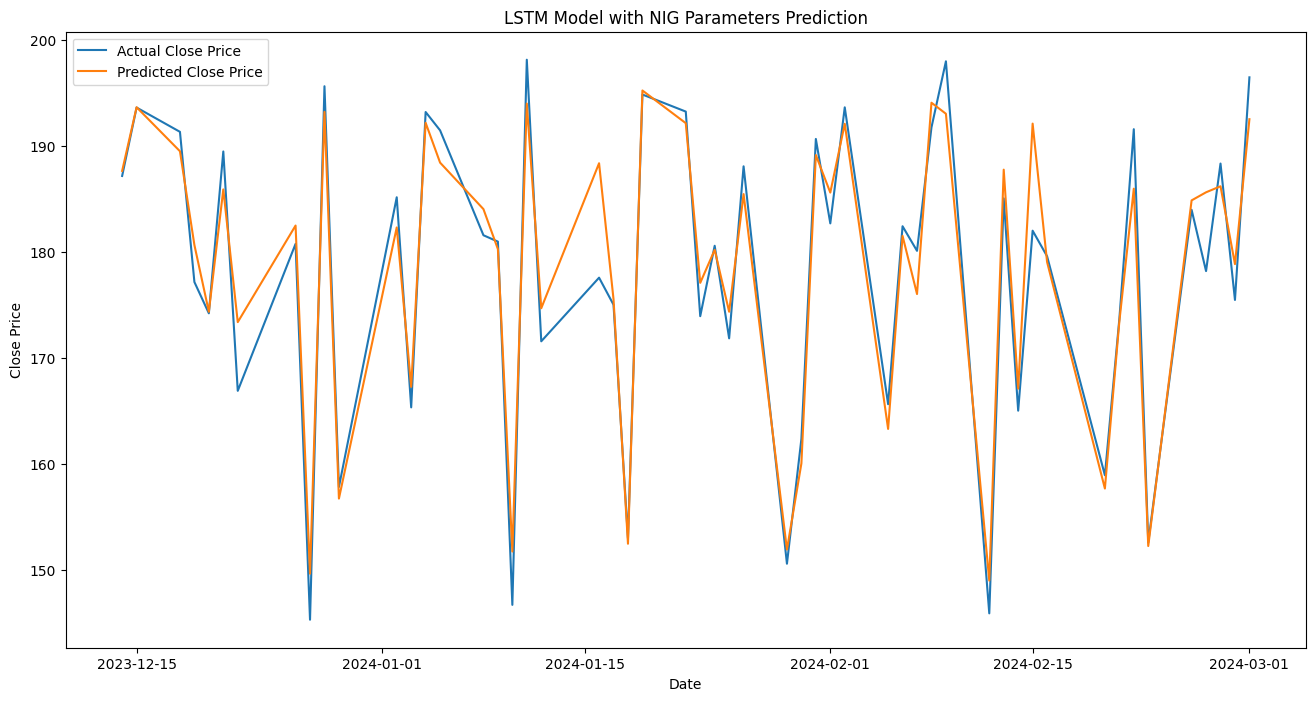

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from scipy import integrate


data_path = '/content/Apple_stock_yahoo_closehigh.csv'
df = pd.read_csv(data_path)


df['Date'] = pd.to_datetime(df['Date'])

data = df[['Close']].values


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


window_size = 30

X, y = [], []
for i in range(window_size, len(data)):
    X.append(scaled_data[i-window_size:i, :])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def estimate_nig_parameters(data):
    # Estimate NIG parameters theta, sigma, and kappa
    log_returns = np.log(data[1:] / data[:-1])
    theta = np.mean(log_returns)
    sigma = np.std(log_returns)
    kappa = 1 / (len(data) - 1) * np.sum((log_returns - theta) ** 2)
    return theta, sigma, kappa

def nig_option_pricing(S0, K, r, T, theta, sigma, kappa):
    # Implement NIG option pricing logic using the Merton model
    # S0: Current stock price
    # K: Option strike price
    # r: Risk-free interest rate
    # T: Time to maturity
    # theta, sigma, kappa: NIG parameters

    # Define parameters for the Merton model
    lambda_ = -theta / kappa
    delta = np.sqrt(theta ** 2 + sigma ** 2 / kappa)
    mu = r - lambda_ * delta - 0.5 * sigma ** 2

    # Calculate the characteristic function of log(S_T)
    def char_func(u):
        return np.exp(T * (1j * u * mu - 0.5 * sigma ** 2 * u ** 2 + kappa * (np.exp(1j * u * np.log(S0)) - 1)))

    # Define the integrand for the option price calculation
    def integrand(u):
        return (np.exp(-1j * u * np.log(K)) * char_func(u) / (1j * u)).real

    # Calculate the option price using numerical integration
    integral_value = integrate.quad(integrand, 0, np.inf)[0]
    option_price = S0 * np.exp(-lambda_ * T) * integral_value / np.pi

    return option_price

theta, sigma, kappa = estimate_nig_parameters(data[:, 0])

X_train_nig = np.zeros((X_train.shape[0], X_train.shape[1], 5))
X_test_nig = np.zeros((X_test.shape[0], X_test.shape[1], 5))
for i in range(X_train.shape[0]):
    X_train_nig[i, :, 0:2] = X_train[i, :, :]
    X_train_nig[i, :, 2:5] = np.array([theta, sigma, kappa])
for i in range(X_test.shape[0]):
    X_test_nig[i, :, 0:2] = X_test[i, :, :]
    X_test_nig[i, :, 2:5] = np.array([theta, sigma, kappa])


model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 5)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_nig, y_train, epochs=100, batch_size=32)


y_pred = model.predict(X_test_nig)


y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), 1)), y_pred), axis=1))[:, 1]
y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), 1)), y_test.reshape(-1, 1)), axis=1))[:, 1]


r2 = r2_score(y_test_inv, y_pred_inv)
print("R-squared (R2) Value:", r2)


mse = mean_squared_error(y_test_inv, y_pred_inv)
print("Mean Squared Error (MSE):", mse)


plt.figure(figsize=(16, 8))
plt.plot(df['Date'].iloc[-len(y_test):], y_test_inv, label='Actual Close Price')
plt.plot(df['Date'].iloc[-len(y_test):], y_pred_inv, label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('LSTM Model with NIG Parameters Prediction')
plt.legend()
plt.show()

#NIG with only Close

Epoch 1/100
7/7 [==============================] - 5s 30ms/step - loss: 0.3677
Epoch 2/100
7/7 [==============================] - 0s 30ms/step - loss: 0.0461
Epoch 3/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0148
Epoch 4/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0177
Epoch 5/100
7/7 [==============================] - 0s 41ms/step - loss: 0.0104
Epoch 6/100
7/7 [==============================] - 0s 50ms/step - loss: 0.0080
Epoch 7/100
7/7 [==============================] - 0s 48ms/step - loss: 0.0072
Epoch 8/100
7/7 [==============================] - 0s 46ms/step - loss: 0.0055
Epoch 9/100
7/7 [==============================] - 0s 45ms/step - loss: 0.0053
Epoch 10/100
7/7 [==============================] - 0s 47ms/step - loss: 0.0050
Epoch 11/100
7/7 [==============================] - 0s 49ms/step - loss: 0.0047
Epoch 12/100
7/7 [==============================] - 0s 52ms/step - loss: 0.0047
Epoch 13/100
7/7 [==============================]

2/2 [==============================] - 1s 15ms/step
R-squared (R2) Value: 0.9435204664796578
Mean Squared Error (MSE): 0.00926382750007823


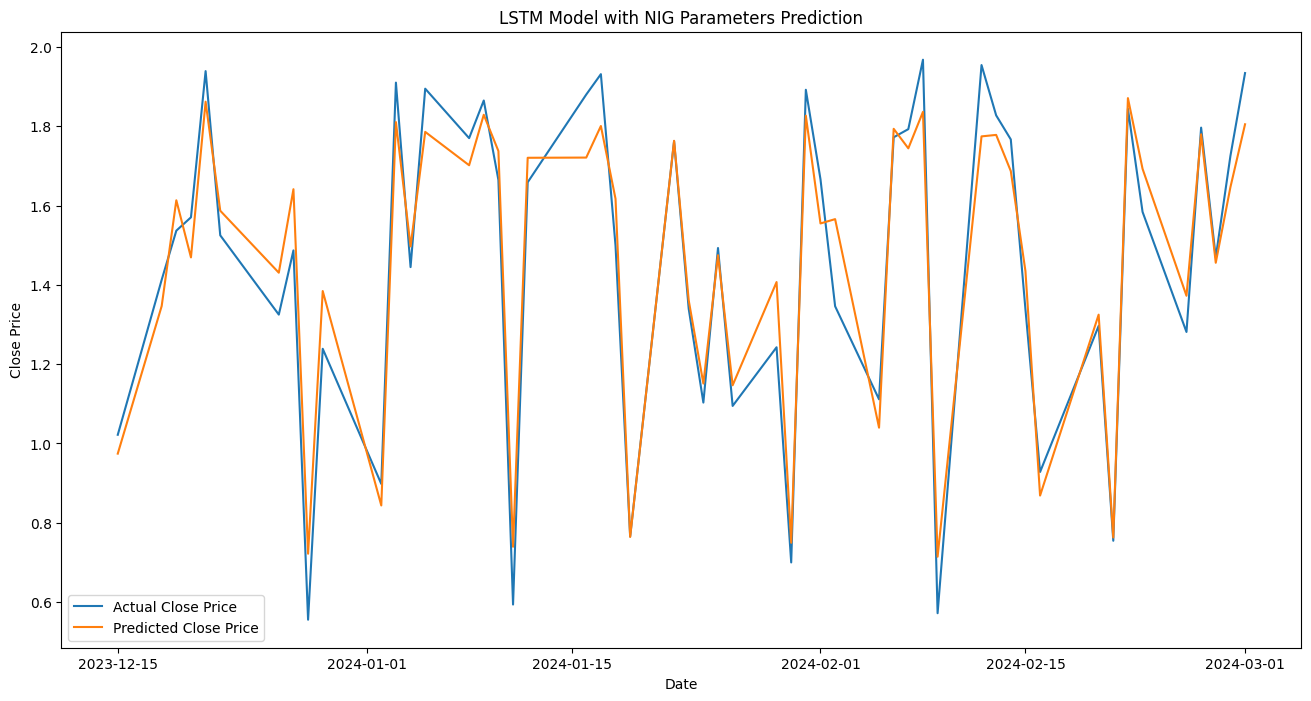

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from scipy import integrate


df1_path = '/content/Apple_close_high_sent.csv'
df1 = pd.read_csv(df1_path)


df2_path = '/content/Apple_stock_yahoo_closehigh.csv'
df2 = pd.read_csv(df2_path)


merged_df = pd.merge(df1, df2, on='Date', how='inner')
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
merged_df['Sent'] = label_encoder.fit_transform(merged_df['Sent'])

# Preprocess the merged dataset
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
data = merged_df[['Close', 'Sent']].values


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)



merged_df['Date'] = pd.to_datetime(merged_df['Date'])
data = merged_df[['Close', 'Sent']].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


window_size = 30


X, y = [], []
for i in range(window_size, len(data)):
    X.append(scaled_data[i-window_size:i, :])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def estimate_nig_parameters(data):
    # Estimate NIG parameters theta, sigma, and kappa
    log_returns = np.log(data[1:] / data[:-1])
    theta = np.mean(log_returns)
    sigma = np.std(log_returns)
    kappa = 1 / (len(data) - 1) * np.sum((log_returns - theta) ** 2)
    return theta, sigma, kappa

def nig_option_pricing(S0, K, r, T, theta, sigma, kappa):
    # Implement NIG option pricing logic using the Merton model
    # S0: Current stock price
    # K: Option strike price
    # r: Risk-free interest rate
    # T: Time to maturity
    # theta, sigma, kappa: NIG parameters

    # Define parameters for the Merton model
    lambda_ = -theta / kappa
    delta = np.sqrt(theta ** 2 + sigma ** 2 / kappa)
    mu = r - lambda_ * delta - 0.5 * sigma ** 2

    # Calculate the characteristic function of log(S_T)
    def char_func(u):
        return np.exp(T * (1j * u * mu - 0.5 * sigma ** 2 * u ** 2 + kappa * (np.exp(1j * u * np.log(S0)) - 1)))

    # Define the integrand for the option price calculation
    def integrand(u):
        return (np.exp(-1j * u * np.log(K)) * char_func(u) / (1j * u)).real

    # Calculate the option price using numerical integration
    integral_value = integrate.quad(integrand, 0, np.inf)[0]
    option_price = S0 * np.exp(-lambda_ * T) * integral_value / np.pi

    return option_price

# Estimate NIG parameters
theta, sigma, kappa = estimate_nig_parameters(data[:, 0])


X_train_nig = np.zeros((X_train.shape[0], X_train.shape[1], 5))
X_test_nig = np.zeros((X_test.shape[0], X_test.shape[1], 5))
for i in range(X_train.shape[0]):
    X_train_nig[i, :, 0:2] = X_train[i, :, :]
    X_train_nig[i, :, 2:5] = np.array([theta, sigma, kappa])
for i in range(X_test.shape[0]):
    X_test_nig[i, :, 0:2] = X_test[i, :, :]
    X_test_nig[i, :, 2:5] = np.array([theta, sigma, kappa])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 5)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_nig, y_train, epochs=100, batch_size=32)


y_pred = model.predict(X_test_nig)


y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), 1)), y_pred), axis=1))[:, 1]
y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), 1)), y_test.reshape(-1, 1)), axis=1))[:, 1]


r2 = r2_score(y_test_inv, y_pred_inv)
print("R-squared (R2) Value:", r2)


mse = mean_squared_error(y_test_inv, y_pred_inv)
print("Mean Squared Error (MSE):", mse)


plt.figure(figsize=(16, 8))
plt.plot(df['Date'].iloc[-len(y_test):], y_test_inv, label='Actual Close Price')
plt.plot(df['Date'].iloc[-len(y_test):], y_pred_inv, label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('LSTM Model with NIG Parameters Prediction')
plt.legend()
plt.show()
